In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST,ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)


def show_tensor_images(image_tensor,num_images=25,size=(1,128,128)):
    print(image_tensor.shape)
    image_tensor=(image_tensor+1)/2
    image_unflat=image_tensor.detach().cpu()
    image_grid= make_grid(image_unflat[:num_images],nrow=5)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()
    

In [2]:
class Generator(nn.Module):
    def __init__(self,z_dim=10,im_chan=3,hidden_dim=64):
        super(Generator,self).__init__()
        self.z_dim=z_dim
        self.gen=nn.Sequential(
        self.make_gen_block(z_dim,hidden_dim*8,kernel_size=4,stride=1,padding=0), # ch x 4 x4
        self.make_gen_block(hidden_dim * 8,hidden_dim * 4,kernel_size=4,stride=2,padding=1),  #ch x 8 x8
        self.make_gen_block(hidden_dim * 4,hidden_dim*2,kernel_size=4,stride=2,padding=1), # ch x 16 x 16
        self.make_gen_block(hidden_dim * 2,hidden_dim*1,kernel_size=4,stride=2,padding=1), # ch x 32 x 32
        self.make_gen_block(hidden_dim * 1,hidden_dim*1,kernel_size=4,stride=2,padding=1), # ch x 64 x 64
        self.make_gen_block(hidden_dim,im_chan,kernel_size=4,stride=2,padding=1,final_layer=True), # 128 X 128
        )
        
    def make_gen_block(self, input_channels,output_channels,kernel_size=3,stride=2,padding=0,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
                
            )
        else:
            return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding),
            nn.Tanh()
            
            )
    def unsqueeze_noise(self,noise):
        return noise.view(len(noise),self.z_dim,1,1)
    
    def forward(self,noise):
        x=self.unsqueeze_noise(noise)
        return self.gen(x)
    
    
    
    
def get_noise(n_sample,z_dim,device='cpu'):
    return torch.randn(n_sample,z_dim,device=device)
    

In [6]:
class Critic(nn.Module):
    def __init__(self,im_chan=3,hidden_dim=16):
        super(Critic,self).__init__()
        self.disc=nn.Sequential(
        self.make_disc_block(im_chan,hidden_dim),
        self.make_disc_block(hidden_dim,hidden_dim*2),
        self.make_disc_block(hidden_dim*2,hidden_dim*4),
        self.make_disc_block(hidden_dim*4,hidden_dim*8),
        self.make_disc_block(hidden_dim*8,1,kernel_size=4,stride=1,padding=0,final_layer=True),
        )
    
    def make_disc_block(self,input_channels,output_channels,kernel_size=4,stride=2,padding=1,final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride,padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
            nn.Conv2d(input_channels,output_channels,kernel_size,stride,padding),
#             nn.LeakyReLU(0.2)
        )
        
    def forward(self,image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred),-1)

In [7]:
criterion=nn.BCEWithLogitsLoss()
z_dim=128
display_step=500
batch_size=128
lr=0.0002

beta_1=0.5
beta_2=0.999
device='cuda'

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data=ImageFolder(root="P:/dataset/Flickr-Faces/thumbnails128x128",transform=transform)
dataloader=DataLoader(dataset=data,batch_size=batch_size,shuffle=True,num_workers=4)

# dataloader=DataLoader(
# MNIST('.',download=False,transform=transform),
# batch_size=batch_size,
# shuffle=True
# )


In [8]:
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr,betas=(beta_1,beta_2))
crit=Critic().to(device)
crit_opt=torch.optim.Adam(crit.parameters(),lr=lr,betas=(beta_1,beta_2))
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


In [17]:
def get_gradient(crit,real,fake,epsilon):
    mixed_images=real*epsilon + fake*(1-epsilon)
    mixed_scores= crit(mixed_images)
    gradient=torch.autograd.grad(
        
        inputs=mixed_images,
        outputs=mixed_scores,
        
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
     
    )[0] 
    return gradient


def gradient_penalty(gradient):
    gradient=gradient.view(len(gradient),-1)
    gradient_norm=gradient.norm(2,dim=1)
    
    penalty=torch.mean((gradient_norm-1)**2)
    
    return penalty

In [20]:
def get_gen_loss(crit_fake_pred):
    return -torch.mean(crit_fake_pred)

def get_crit_loss(crit_fake_pred,crit_real_pred,gp,c_lambda):
    crit_loss=torch.mean(crit_fake_pred)-torch.mean(crit_real_pred)+gp*c_lambda
    
    return crit_loss


Step / Epoch : 500 / 0 :Generator loss: -0.42668370110099174, discriminator loss: 0
torch.Size([128, 3, 128, 128])


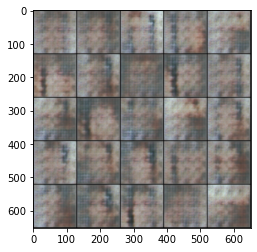

torch.Size([128, 3, 128, 128])


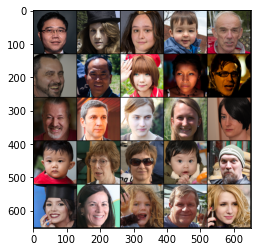

Step / Epoch : 1000 / 1 :Generator loss: -1.7798588191568845, discriminator loss: 0
torch.Size([128, 3, 128, 128])


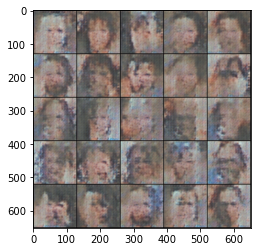

torch.Size([128, 3, 128, 128])


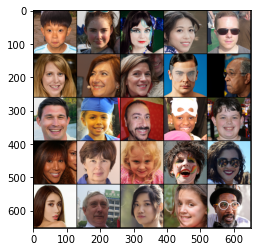

Step / Epoch : 1500 / 2 :Generator loss: -0.9243244443535806, discriminator loss: 0
torch.Size([128, 3, 128, 128])


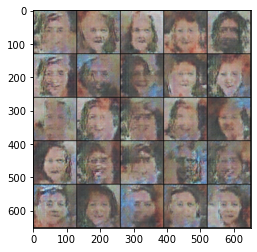

torch.Size([128, 3, 128, 128])


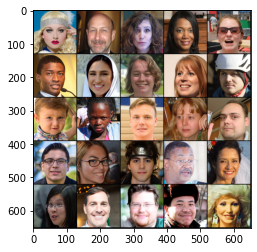

Step / Epoch : 2000 / 3 :Generator loss: -2.5756980929374707, discriminator loss: 0
torch.Size([128, 3, 128, 128])


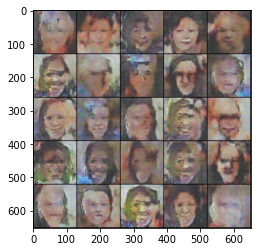

torch.Size([128, 3, 128, 128])


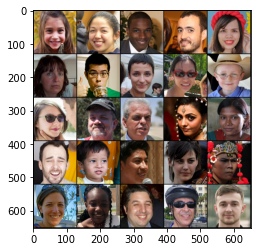

Step / Epoch : 2500 / 4 :Generator loss: -3.5533077230453487, discriminator loss: 0
torch.Size([128, 3, 128, 128])


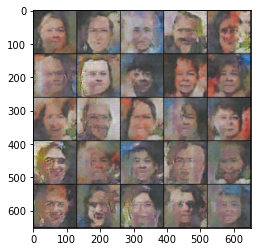

torch.Size([128, 3, 128, 128])


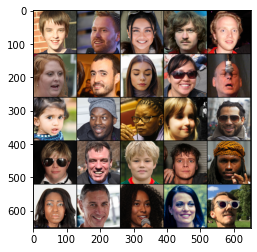

Step / Epoch : 3000 / 5 :Generator loss: -4.948730243206025, discriminator loss: 0
torch.Size([128, 3, 128, 128])


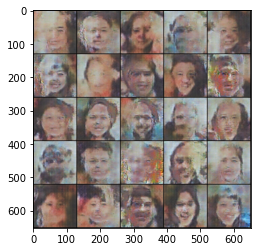

torch.Size([128, 3, 128, 128])


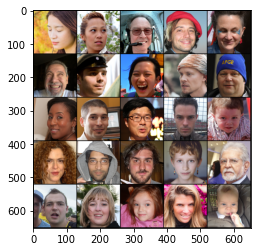

Step / Epoch : 3500 / 6 :Generator loss: -6.188434262275693, discriminator loss: 0
torch.Size([128, 3, 128, 128])


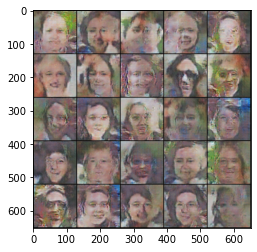

torch.Size([128, 3, 128, 128])


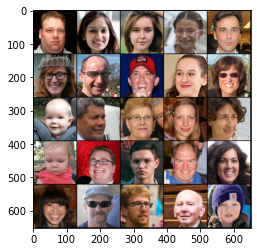

Step / Epoch : 4000 / 7 :Generator loss: -7.1923058338165315, discriminator loss: 0
torch.Size([128, 3, 128, 128])


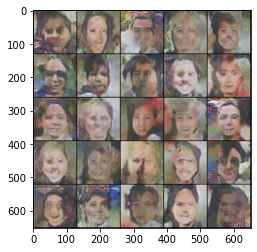

torch.Size([128, 3, 128, 128])


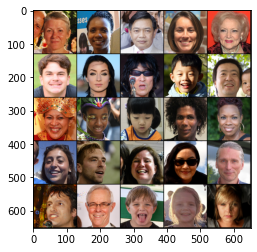

Step / Epoch : 4500 / 8 :Generator loss: -8.004635658264162, discriminator loss: 0
torch.Size([128, 3, 128, 128])


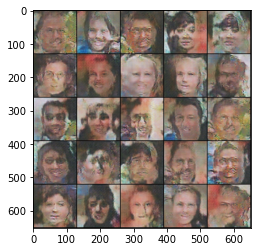

torch.Size([128, 3, 128, 128])


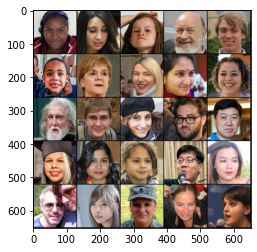

Step / Epoch : 5000 / 9 :Generator loss: -8.110390541076658, discriminator loss: 0
torch.Size([128, 3, 128, 128])


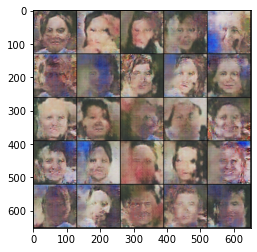

torch.Size([128, 3, 128, 128])


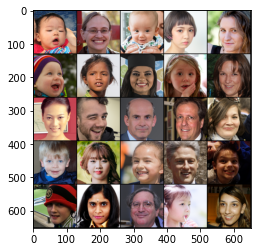

Step / Epoch : 5500 / 10 :Generator loss: -8.652679934501645, discriminator loss: 0
torch.Size([128, 3, 128, 128])


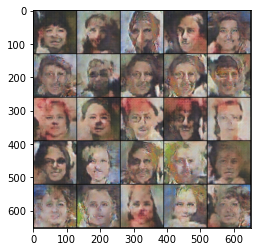

torch.Size([128, 3, 128, 128])


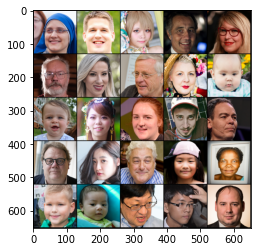

Step / Epoch : 6000 / 11 :Generator loss: -8.942566617965689, discriminator loss: 0
torch.Size([128, 3, 128, 128])


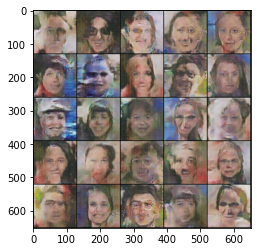

torch.Size([128, 3, 128, 128])


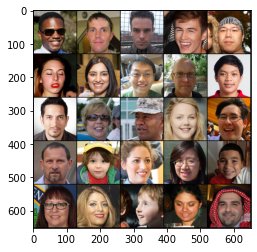

KeyboardInterrupt: 

In [21]:
n_epochs=50
cur_step=0
mean_generator_loss=0
mean_critic_loss=0
crit_repeat=5
c_lambda=10
for epoch in range(n_epochs):
  
    for i,(real,_) in enumerate(dataloader):
        cur_batch_size=len(real)
        real=real.to(device)
        mean_crit_loss=0
        for _ in range(crit_repeat):
            crit_opt.zero_grad()
            fake_noise=get_noise(cur_batch_size,z_dim,device=device)
            fake=gen(fake_noise)
            crit_fake_pred=crit(fake.detach())
        
            crit_real_pred=crit(real)
       
            epsilon=torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient=get_gradient(crit,real,fake.detach(),epsilon)
            gp=gradient_penalty(gradient)
            crit_loss=get_crit_loss(crit_fake_pred,crit_real_pred,gp,c_lambda)
            mean_crit_loss=crit_loss.item()/crit_repeat
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
          
        
        gen_opt.zero_grad()
        fake_noise_2=get_noise(cur_batch_size,z_dim,device=device)
        fake_2=gen(fake_noise_2)
        crit_fake_pred=crit(fake_2)
        gen_loss=get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        
        mean_generator_loss+=gen_loss.item()/display_step
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step / Epoch : {cur_step} / {epoch} :Generator loss: {mean_generator_loss}, discriminator loss: {mean_critic_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
    
        
        

In [22]:
img_list=gen(get_noise(25,z_dim,device=device)).detach().cpu()

In [23]:
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

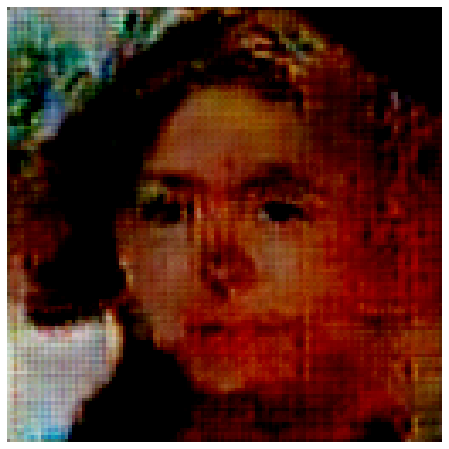

In [24]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [25]:
for param_tensor in gen.state_dict():
    print(param_tensor, "\t", gen.state_dict()[param_tensor].size())

gen.0.0.weight 	 torch.Size([128, 512, 4, 4])
gen.0.0.bias 	 torch.Size([512])
gen.0.1.weight 	 torch.Size([512])
gen.0.1.bias 	 torch.Size([512])
gen.0.1.running_mean 	 torch.Size([512])
gen.0.1.running_var 	 torch.Size([512])
gen.0.1.num_batches_tracked 	 torch.Size([])
gen.1.0.weight 	 torch.Size([512, 256, 4, 4])
gen.1.0.bias 	 torch.Size([256])
gen.1.1.weight 	 torch.Size([256])
gen.1.1.bias 	 torch.Size([256])
gen.1.1.running_mean 	 torch.Size([256])
gen.1.1.running_var 	 torch.Size([256])
gen.1.1.num_batches_tracked 	 torch.Size([])
gen.2.0.weight 	 torch.Size([256, 128, 4, 4])
gen.2.0.bias 	 torch.Size([128])
gen.2.1.weight 	 torch.Size([128])
gen.2.1.bias 	 torch.Size([128])
gen.2.1.running_mean 	 torch.Size([128])
gen.2.1.running_var 	 torch.Size([128])
gen.2.1.num_batches_tracked 	 torch.Size([])
gen.3.0.weight 	 torch.Size([128, 64, 4, 4])
gen.3.0.bias 	 torch.Size([64])
gen.3.1.weight 	 torch.Size([64])
gen.3.1.bias 	 torch.Size([64])
gen.3.1.running_mean 	 torch.Size([64]

In [26]:
torch.save(gen.state_dict(),".\\DCGAN_with_Wasserstein Loss_faces-.pickle")

In [ ]:
# torch.save(disc.state_dict(),".\\DCGAN_faces_disc.pickle")

In [27]:
model = Generator(z_dim)
model.load_state_dict(torch.load(".\\DCGAN_faces_gen.pickle"))
model.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTr

In [28]:
image=model(get_noise(25,128))

torch.Size([25, 3, 128, 128])


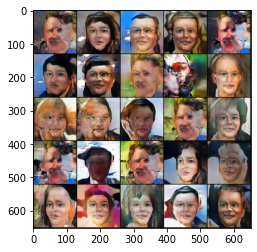

In [29]:
show_tensor_images(image)